In [41]:
import pandas as pd
import numpy as np

In [18]:
pitchfork_df = pd.read_csv('pitchfork1.csv')
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork2.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork3.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork4.csv'))
pitchfork_df = pitchfork_df.reset_index()
print(pitchfork_df.shape)

(12168, 8)


In [21]:
import matplotlib as plt
import seaborn as sns

In [37]:
# Hmmm. Why are some of the scores Nan? I am going to turn them into -1
# for now. I think that we should either get a real score for them, or remove them
# from the dataset. Other thoughts?
pitchfork_df.head()
values = {'score':-1}
pitchfork_df = pitchfork_df.fillna(value=values)
#pitchfork_df['score'].values

/Users/johncrider/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


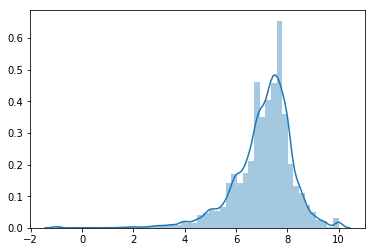

In [38]:
sns.distplot(pitchfork_df['score'].values)

In [69]:
print(np.std(pitchfork_df['score'].values))
print(np.mean(pitchfork_df['score'].values))
print(pitchfork_df['album'][:2])
print(pitchfork_df['album'][:2][0])


1.1352786888290622
7.090154503616042
0                 DJ-Kicks
1    I Trawl the Megahertz
Name: album, dtype: object
DJ-Kicks


In [70]:
pitchfork_df.head()

,Unnamed: 0,artist,album,score,genre,review,best,date
0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,"On her first commercial mix album, the produce...",0,11 hrs ago
1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,Best new reissue This lost Prefab Sprout album...,1,11 hrs ago
2,2,USA/Mexico,Matamoros,7.3,Rock,"USA/Mexico are sludgy, nasty, and unclassifiab...",0,11 hrs ago
3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,"On her new album, Tamaryn aims for sky-high '8...",0,11 hrs ago
4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,Best new music The rapturous debut from the Br...,1,March 22 2019


In [74]:
# I picked 7.0 as an arbitrary cutoff between good and bad.

pitchfork_df['rating'] = np.where(pitchfork_df['score']>7.0,1,0)

In [75]:
pitchfork_df.head()

,Unnamed: 0,artist,album,score,genre,review,best,date,rating
0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,"On her first commercial mix album, the produce...",0,11 hrs ago,1
1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,Best new reissue This lost Prefab Sprout album...,1,11 hrs ago,1
2,2,USA/Mexico,Matamoros,7.3,Rock,"USA/Mexico are sludgy, nasty, and unclassifiab...",0,11 hrs ago,1
3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,"On her new album, Tamaryn aims for sky-high '8...",0,11 hrs ago,0
4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,Best new music The rapturous debut from the Br...,1,March 22 2019,1


In [80]:
pitchfork_df['review'][0][0]

0    On her first commercial mix album, the produce...
0    After a scooter accident almost killed him, Wi...
0    The 11 irresistibly fun songs on Brooklyn indi...
0    The Compton-based, Dr. Dre-affiliated rapper s...
Name: review, dtype: object

In [95]:
def cleanReview(stringToClean):
    return prepStringForProcessing(stringToClean)

def prepStringForProcessing(inputString):
    # this code cleans a string. It takes
    # a string and removes the puncuation 
    # from the string. The cleaned string 
    # is returned
    
    # remove puncuation
    outputString = inputString.replace(',','')
    outputString = outputString.replace('.','')
    outputString = outputString.replace(':','')
    outputString = outputString.replace(';','')
    outputString = outputString.replace('@','')
    outputString = outputString.replace('"','')
    outputString = outputString.replace("'","")
    outputString = outputString.replace("'","")
    outputString = outputString.replace('?','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('#','')
    outputString = outputString.replace('%','')
    outputString = outputString.replace('&','')
    outputString = outputString.replace('$','')
    outputString = outputString.replace('^','')
    outputString = outputString.replace('*','')
    outputString = outputString.replace('(','')
    outputString = outputString.replace(')','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('-','')
    return outputString.lower();


In [96]:
for i in range(0,len(pitchfork_df)-1):
    pitchfork_df['review'][i] = cleanReview(pitchfork_df['review'][i])

/Users/johncrider/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [97]:
pitchfork_df.head()

,index,Unnamed: 0,artist,album,score,genre,review,best,date,rating
0,0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,on her first commercial mix album the producer...,0,11 hrs ago,1
1,1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,best new reissue this lost prefab sprout album...,1,11 hrs ago,1
2,2,2,USA/Mexico,Matamoros,7.3,Rock,usa/mexico are sludgy nasty and unclassifiable...,0,11 hrs ago,1
3,3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,on her new album tamaryn aims for skyhigh 80sg...,0,11 hrs ago,0
4,4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,best new music the rapturous debut from the br...,1,March 22 2019,1


In [103]:
import nltk
from nltk.stem.porter import PorterStemmer

def tokenizeStem(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [106]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer,TfidfTransformer  
from sklearn.model_selection import GridSearchCV  
from sklearn.naive_bayes import MultinomialNB  

from sklearn.pipeline import Pipeline  
from time import time  
from sklearn.svm import LinearSVC

In [108]:


minisize = .99

t0 = time()  
X = pitchfork_df['review']
y = pitchfork_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=minisize, random_state=42)
X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(X_test, y_test,test_size=0.25)

pipeline = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenizeStem, max_df=0.5, max_features=700000, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer()), 
    ('clf', LinearSVC())])
pipeline.fit(X_train_mini, y_train_mini)
print(pipeline)
print(pipeline.score(X_test_mini, y_test_mini))

print("done in {0}s".format(time() - t0))  

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=700000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        stri...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.7739043824701195
done in 242.16569328308105s


In [109]:

print(pipeline.score(X_test_mini, y_test_mini))

0.7739043824701195
